In [1]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import    mean_absolute_error
from sklearn.metrics import    median_absolute_error
from sklearn.model_selection import train_test_split  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout 


C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [3]:
dataset = pd.read_excel('C:\data\day.xlsx')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 5 columns):
date_n            1095 non-null int64
Zipcode           1095 non-null int64
TempHigh_day_f    1095 non-null int64
Humidity          1095 non-null int64
Humidity_1        1095 non-null int64
dtypes: int64(5)
memory usage: 42.9 KB


In [4]:
#embeddings  to get max value

MAX_NAME_SEQ = 16
MAX_TEXT = np.max([dataset.date_n.max()])+1
MAX_DEGREE = np.max([dataset.Zipcode.max()])+1
MAX_Alarm_Action = np.max([dataset.TempHigh_day_f.max()])+1



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002763256A358>]],
      dtype=object)

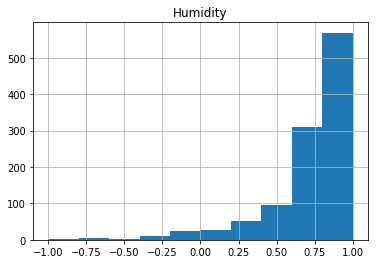

In [5]:
#SCALE kpi_num variable
dataset["Humidity"] = np.log(dataset.Humidity+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
dataset["Humidity"] = target_scaler.fit_transform(dataset.Humidity.reshape(-1,1))
pd.DataFrame(dataset.Humidity).hist()

In [6]:
xx,yy=train_test_split(dataset, random_state=0,train_size=0.70)
dtrain, dvalid = train_test_split(dataset, random_state=0,train_size=0.70)
print(dtrain.shape)
print(dvalid.shape)



(766, 5)
(329, 5)


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
         'name':np.array(dataset.date_n),
        'Degree': np.array(dataset.Zipcode),
        'Alarm_Action': np.array(dataset.TempHigh_day_f)
    }
    return X
x = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(dataset)


In [8]:

from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    
    #Inputs
    name = Input(shape=[1], name="name")
    Degree = Input(shape=[1], name="Degree")
    Alarm_Action = Input(shape=[1], name="Alarm_Action")
    
    #Embeddings layers
    
    emb_name = Embedding(MAX_TEXT, 10)(name)
    emb_Degree = Embedding(MAX_DEGREE, 20)(Degree)
    emb_Alarm_Action = Embedding(MAX_Alarm_Action, 20)(Alarm_Action)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_name)
 
    #main layer
    main_l = concatenate([
        Flatten() (emb_Degree)
        ,Flatten() (emb_Alarm_Action)
        ,rnn_layer1
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
        #model
    model = Model([name,Degree,Alarm_Action], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Degree (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
Alarm_Action (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
name (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 20)        210000      Degree[0][0]                     
__________________________________________________________________________________________________
embedding_

In [9]:
#FITTING THE MODEL
BATCH_SIZE = 1550
epochs =5

model = get_model()


In [10]:
model.fit(x, dtrain.Humidity, epochs=epochs,
          batch_size=BATCH_SIZE , 
          validation_data=(X_valid,dvalid.Humidity))

val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1


Train on 766 samples, validate on 329 samples
Epoch 1/5
766/766 [==============================] - 1s 1ms/step - loss: 0.6088 - mean_absolute_error: 0.7444 - rmsle_cust: 0.5248 - val_loss: 0.5686 - val_mean_absolute_error: 0.7217 - val_rmsle_cust: 0.5098
Epoch 2/5
766/766 [==============================] - 0s 54us/step - loss: 0.5570 - mean_absolute_error: 0.7111 - rmsle_cust: 0.5030 - val_loss: 0.5196 - val_mean_absolute_error: 0.6879 - val_rmsle_cust: 0.4796
Epoch 3/5
766/766 [==============================] - 0s 56us/step - loss: 0.5069 - mean_absolute_error: 0.6769 - rmsle_cust: 0.4732 - val_loss: 0.4698 - val_mean_absolute_error: 0.6520 - val_rmsle_cust: 0.4473
Epoch 4/5
766/766 [==============================] - 0s 50us/step - loss: 0.4583 - mean_absolute_error: 0.6424 - rmsle_cust: 0.4420 - val_loss: 0.4185 - val_mean_absolute_error: 0.6128 - val_rmsle_cust: 0.4129
Epoch 5/5
766/766 [==============================] - 0s 51us/step - loss: 0.4060 - mean_absolute_error: 0.6029 - rm

In [11]:
#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.Humidity.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))


 RMSLE error on dev test: 4.2888091147663285


In [12]:
a=val_preds
a.tolist()

[[70.6927490234375],
 [67.50686645507812],
 [67.76134490966797],
 [70.0218505859375],
 [67.65907287597656],
 [67.69608306884766],
 [70.58744812011719],
 [71.48387908935547],
 [70.08556365966797],
 [68.6649398803711],
 [71.35033416748047],
 [71.7301254272461],
 [68.85372924804688],
 [69.24166870117188],
 [66.87474060058594],
 [67.6771011352539],
 [71.7999038696289],
 [72.12759399414062],
 [70.15177917480469],
 [67.34061431884766],
 [68.62964630126953],
 [74.26008605957031],
 [69.95011138916016],
 [69.96760559082031],
 [68.58396911621094],
 [68.7227783203125],
 [68.69246673583984],
 [70.41710662841797],
 [66.82920837402344],
 [70.78878784179688],
 [69.74535369873047],
 [66.97036743164062],
 [66.99707794189453],
 [70.0023422241211],
 [70.13044738769531],
 [65.38822937011719],
 [66.9899673461914],
 [70.705078125],
 [71.14875030517578],
 [67.3851089477539],
 [70.36197662353516],
 [70.74966430664062],
 [70.51846313476562],
 [70.78652954101562],
 [67.64369201660156],
 [66.42184448242188],
 [7

In [13]:
predict_humidity= pd.DataFrame(a)


In [14]:
predict_humidity.columns=['predict_humidity']


In [15]:
real_data=dvalid.Humidity_1


In [16]:
real_data_df= real_data.to_frame()

In [18]:
real_data_df.to_excel('C:/data/real_data_df.xlsx')
predict_humidity.to_excel('C:/data/predict_humidity.xlsx')
